# Notebook 06: Centrality & Influence Analysis

**Objective**: Identify the most important and influential Digimon in the knowledge graph.

This notebook explores:
- Various centrality measures (degree, betweenness, closeness, eigenvector, PageRank)
- Custom influence metrics
- Comparative analysis of centrality measures
- Visualization of influential nodes

---

## 1. Setup and Imports

In [19]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Custom utilities
from utils import (
    Neo4jConnector,
    calculate_centrality_measures,
    plot_centrality_comparison,
    plot_network_static,
    save_figure,
    TYPE_COLORS, LEVEL_COLORS, ATTRIBUTE_COLORS
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

# Notebook configuration
notebook_name = "06_centrality_analysis"

print("Environment setup complete!")

Environment setup complete!


## 2. Build Network Graphs

In [20]:
# Connect to database
conn = Neo4jConnector()
print("Connected to Neo4j database")

# Get all data
digimon_df = conn.get_all_digimon()
evolution_data = conn.get_evolution_chains()
moves_df = conn.get_digimon_moves()

# Remove any rows with missing name_en
digimon_df = digimon_df.dropna(subset=['name_en'])

print(f"\nLoaded data:")
print(f"  - {len(digimon_df)} Digimon (with valid names)")
print(f"  - {len(evolution_data)} evolution relationships")
print(f"  - {len(moves_df)} move relationships")

Connected to Neo4j database

Loaded data:
  - 1249 Digimon (with valid names)
  - 3746 evolution relationships
  - 2433 move relationships


In [21]:
# Build multiple network representations

# 1. Evolution Network (Directed)
evolution_graph = nx.DiGraph()
for _, digimon in digimon_df.iterrows():
    if digimon['name_en'] is not None:  # Safety check
        evolution_graph.add_node(
            digimon['name_en'],
            level=digimon['level'],
            type=digimon['type'],
            attribute=digimon['attribute']
        )

for evo in evolution_data:
    if evo['from_digimon'] in evolution_graph and evo['to_digimon'] in evolution_graph:
        evolution_graph.add_edge(evo['from_digimon'], evo['to_digimon'])

print(f"Evolution network: {evolution_graph.number_of_nodes()} nodes, {evolution_graph.number_of_edges()} edges")

# 2. Similarity Network (Undirected) - based on shared attributes
similarity_graph = nx.Graph()
for _, digimon in digimon_df.iterrows():
    if digimon['name_en'] is not None:  # Safety check
        similarity_graph.add_node(
            digimon['name_en'],
            level=digimon['level'],
            type=digimon['type'],
            attribute=digimon['attribute']
        )

# Add edges for shared types (sample for efficiency)
type_groups = digimon_df.groupby('type')['name_en'].apply(list)
for type_name, digimon_list in type_groups.items():
    if 2 <= len(digimon_list) <= 30:  # Reasonable group sizes
        for i in range(len(digimon_list)):
            for j in range(i + 1, min(i + 5, len(digimon_list))):
                similarity_graph.add_edge(digimon_list[i], digimon_list[j], weight=1.0)

# Add edges for shared moves
move_groups = moves_df.groupby('move')['digimon'].apply(list)
for move, digimon_list in move_groups.items():
    if 2 <= len(digimon_list) <= 10:  # Rare moves only
        for i in range(len(digimon_list)):
            for j in range(i + 1, len(digimon_list)):
                if digimon_list[i] in similarity_graph and digimon_list[j] in similarity_graph:
                    if similarity_graph.has_edge(digimon_list[i], digimon_list[j]):
                        similarity_graph[digimon_list[i]][digimon_list[j]]['weight'] += 0.5
                    else:
                        similarity_graph.add_edge(digimon_list[i], digimon_list[j], weight=0.5)

print(f"Similarity network: {similarity_graph.number_of_nodes()} nodes, {similarity_graph.number_of_edges()} edges")

# 3. Combined Network (for comprehensive analysis)
combined_graph = nx.Graph()
# Add all nodes
for node, attrs in evolution_graph.nodes(data=True):
    combined_graph.add_node(node, **attrs)
# Add evolution edges
for u, v in evolution_graph.edges():
    combined_graph.add_edge(u, v, weight=2.0, type='evolution')
# Add similarity edges
for u, v, data in similarity_graph.edges(data=True):
    if combined_graph.has_edge(u, v):
        combined_graph[u][v]['weight'] += data['weight']
    else:
        combined_graph.add_edge(u, v, weight=data['weight'], type='similarity')

print(f"Combined network: {combined_graph.number_of_nodes()} nodes, {combined_graph.number_of_edges()} edges")

Evolution network: 1249 nodes, 3713 edges
Similarity network: 1249 nodes, 2034 edges
Combined network: 1249 nodes, 4916 edges


## 3. Calculate Centrality Measures

In [22]:
# Calculate centrality for evolution network
print("=== EVOLUTION NETWORK CENTRALITY ===")
evolution_centrality = calculate_centrality_measures(evolution_graph)
evolution_centrality = evolution_centrality.sort_values('degree', ascending=False)

print("\nTop 10 by degree centrality (most evolution connections):")
for idx, row in evolution_centrality.head(10).iterrows():
    in_deg = evolution_graph.in_degree(idx) if idx in evolution_graph else 0
    out_deg = evolution_graph.out_degree(idx) if idx in evolution_graph else 0
    print(f"  {idx}: in={in_deg}, out={out_deg}, total={in_deg+out_deg}")

=== EVOLUTION NETWORK CENTRALITY ===

Top 10 by degree centrality (most evolution connections):
  TAILMON: in=18, out=3, total=21
  MUGENDRAMON: in=15, out=3, total=18
  SHOUTMON: in=13, out=3, total=16
  WEZENGAMMAMON: in=13, out=3, total=16
  LUCEMON_X: in=12, out=3, total=15
  GANKOOMON_X: in=12, out=3, total=15
  JESMONGX: in=12, out=3, total=15
  HAWKMON: in=11, out=3, total=14
  MARINANGEMON: in=11, out=3, total=14
  CRANIUMMON_X: in=11, out=3, total=14


In [23]:
# Calculate centrality for similarity network
print("\n=== SIMILARITY NETWORK CENTRALITY ===")
similarity_centrality = calculate_centrality_measures(similarity_graph)
similarity_centrality = similarity_centrality.sort_values('degree', ascending=False)

print("\nTop 10 by degree centrality (most similar Digimon):")
for idx, row in similarity_centrality.head(10).iterrows():
    degree = similarity_graph.degree(idx)
    node_data = similarity_graph.nodes[idx]
    print(f"  {idx} ({node_data['type']}/{node_data['attribute']}): {degree} connections")


=== SIMILARITY NETWORK CENTRALITY ===

Top 10 by degree centrality (most similar Digimon):
  NUMEMON (Fluffy body Type/Virus): 11 connections
  KOROMON (Lesser Type/): 10 connections
  PILLOMON (mammalian Type/Vaccine): 10 connections
  CERBERUMON_X (Demon Beast Type/Vaccine): 10 connections
  BEELZEBUMON:BLASTMODE (Demon King Type/Virus): 10 connections
  CERBERUMON (Demon Beast Type/Vaccine): 10 connections
  PAGUMON (Lesser Type/): 10 connections
  HUCKMON (Little Dragon Type/Data): 10 connections
  GEOGREYMON (dinosaur Type/Vaccine): 9 connections
  SKULLSEADRAMON (Undead Type/Virus): 9 connections


In [24]:
# Calculate centrality for combined network
print("\n=== COMBINED NETWORK CENTRALITY ===")
combined_centrality = calculate_centrality_measures(combined_graph)

# Add node attributes to centrality DataFrame
for node in combined_centrality.index:
    if node in combined_graph:
        attrs = combined_graph.nodes[node]
        combined_centrality.loc[node, 'type'] = attrs.get('type', 'Unknown')
        combined_centrality.loc[node, 'level'] = attrs.get('level', 'Unknown')
        combined_centrality.loc[node, 'attribute'] = attrs.get('attribute', 'Unknown')

print("\nCentrality measures calculated for all networks")


=== COMBINED NETWORK CENTRALITY ===

Centrality measures calculated for all networks


## 4. Custom Influence Metrics

In [25]:
# Calculate custom influence scores
influence_scores = pd.DataFrame(index=combined_centrality.index)

# 1. Evolution Influence Score
# Higher score for Digimon that are central in evolution chains
for node in influence_scores.index:
    if node in evolution_graph:
        ancestors = len(nx.ancestors(evolution_graph, node))
        descendants = len(nx.descendants(evolution_graph, node))
        evolution_influence = (ancestors + descendants * 2) / evolution_graph.number_of_nodes()
    else:
        evolution_influence = 0
    influence_scores.loc[node, 'evolution_influence'] = evolution_influence

# 2. Type Diversity Index
# Score based on connections to different types
for node in influence_scores.index:
    if node in combined_graph:
        neighbor_types = set()
        for neighbor in combined_graph.neighbors(node):
            neighbor_type = combined_graph.nodes[neighbor].get('type', 'Unknown')
            neighbor_types.add(neighbor_type)
        type_diversity = len(neighbor_types) / digimon_df['type'].nunique()
    else:
        type_diversity = 0
    influence_scores.loc[node, 'type_diversity'] = type_diversity

# 3. Move Uniqueness Score
# Higher score for Digimon with rare moves
move_counts = moves_df['move'].value_counts()
for node in influence_scores.index:
    node_moves = moves_df[moves_df['digimon'] == node]['move'].tolist()
    if node_moves:
        # Calculate average rarity of moves (inverse of frequency)
        move_rarities = [1 / move_counts[move] for move in node_moves]
        move_uniqueness = np.mean(move_rarities) * 100
    else:
        move_uniqueness = 0
    influence_scores.loc[node, 'move_uniqueness'] = move_uniqueness

# 4. Combined Influence Score
# Weighted combination of all metrics
influence_scores['combined_influence'] = (
    combined_centrality['degree'] * 0.2 +
    combined_centrality['betweenness'] * 0.2 +
    combined_centrality['eigenvector'] * 0.2 +
    combined_centrality['pagerank'] * 100 * 0.2 +
    influence_scores['evolution_influence'] * 0.1 +
    influence_scores['type_diversity'] * 0.05 +
    influence_scores['move_uniqueness'] * 0.05
)

# Normalize to 0-1 scale
for col in influence_scores.columns:
    if influence_scores[col].max() > 0:
        influence_scores[col] = influence_scores[col] / influence_scores[col].max()

print("Custom influence metrics calculated")

Custom influence metrics calculated


In [26]:
# Combine all metrics
all_metrics = pd.concat([combined_centrality, influence_scores], axis=1)
all_metrics = all_metrics.sort_values('combined_influence', ascending=False)

print("=== TOP 20 MOST INFLUENTIAL DIGIMON ===")
print("\nRank | Digimon | Type | Level | Combined Score")
print("-" * 60)
for i, (idx, row) in enumerate(all_metrics.head(20).iterrows()):
    print(f"{i+1:4d} | {idx:20s} | {row['type']:15s} | {row['level']:10s} | {row['combined_influence']:.3f}")

=== TOP 20 MOST INFLUENTIAL DIGIMON ===

Rank | Digimon | Type | Level | Combined Score
------------------------------------------------------------
   1 | MARINANGEMON         | fairy Type      | Mega       | 1.000
   2 | SKULLKNIGHTMON       | Undead Type     | Maturity (Cross Wars) | 0.998
   3 | HAWKMON              | bird Type       | Rookie     | 0.998
   4 | RAREMON              | Undead Type     | Champion   | 0.997
   5 | ARMADIMON            | mammalian Type  | Rookie     | 0.997
   6 | V-MON                | Little Dragon Type | Rookie     | 0.996
   7 | MUGENDRAMON          | Machine Type    | Mega       | 0.996
   8 | MAQUINAMON           | Synthesis Type  | Rookie     | 0.996
   9 | WORMMON              | Larva Type      | Rookie     | 0.996
  10 | LOTUSMON             | fairy Type      | Mega       | 0.996
  11 | DINOMON              | dinosaur Type   | Mega       | 0.996
  12 | MARINDEVIMON         | Aquatic Beast Man Type | Ultimate   | 0.996
  13 | DIMETROMON         

## 5. Comparative Analysis

=== CENTRALITY MEASURE CORRELATIONS ===
             degree  betweenness  closeness  eigenvector  pagerank
degree        1.000        0.825      0.812        0.820     0.898
betweenness   0.825        1.000      0.785        0.651     0.782
closeness     0.812        0.785      1.000        0.903     0.619
eigenvector   0.820        0.651      0.903        1.000     0.597
pagerank      0.898        0.782      0.619        0.597     1.000
Saved: ../results/06_centrality_analysis/figures/centrality_correlations.png
Saved: ../results/06_centrality_analysis/figures/centrality_correlations.svg
Saved: ../results/06_centrality_analysis/figures/centrality_correlations.pdf


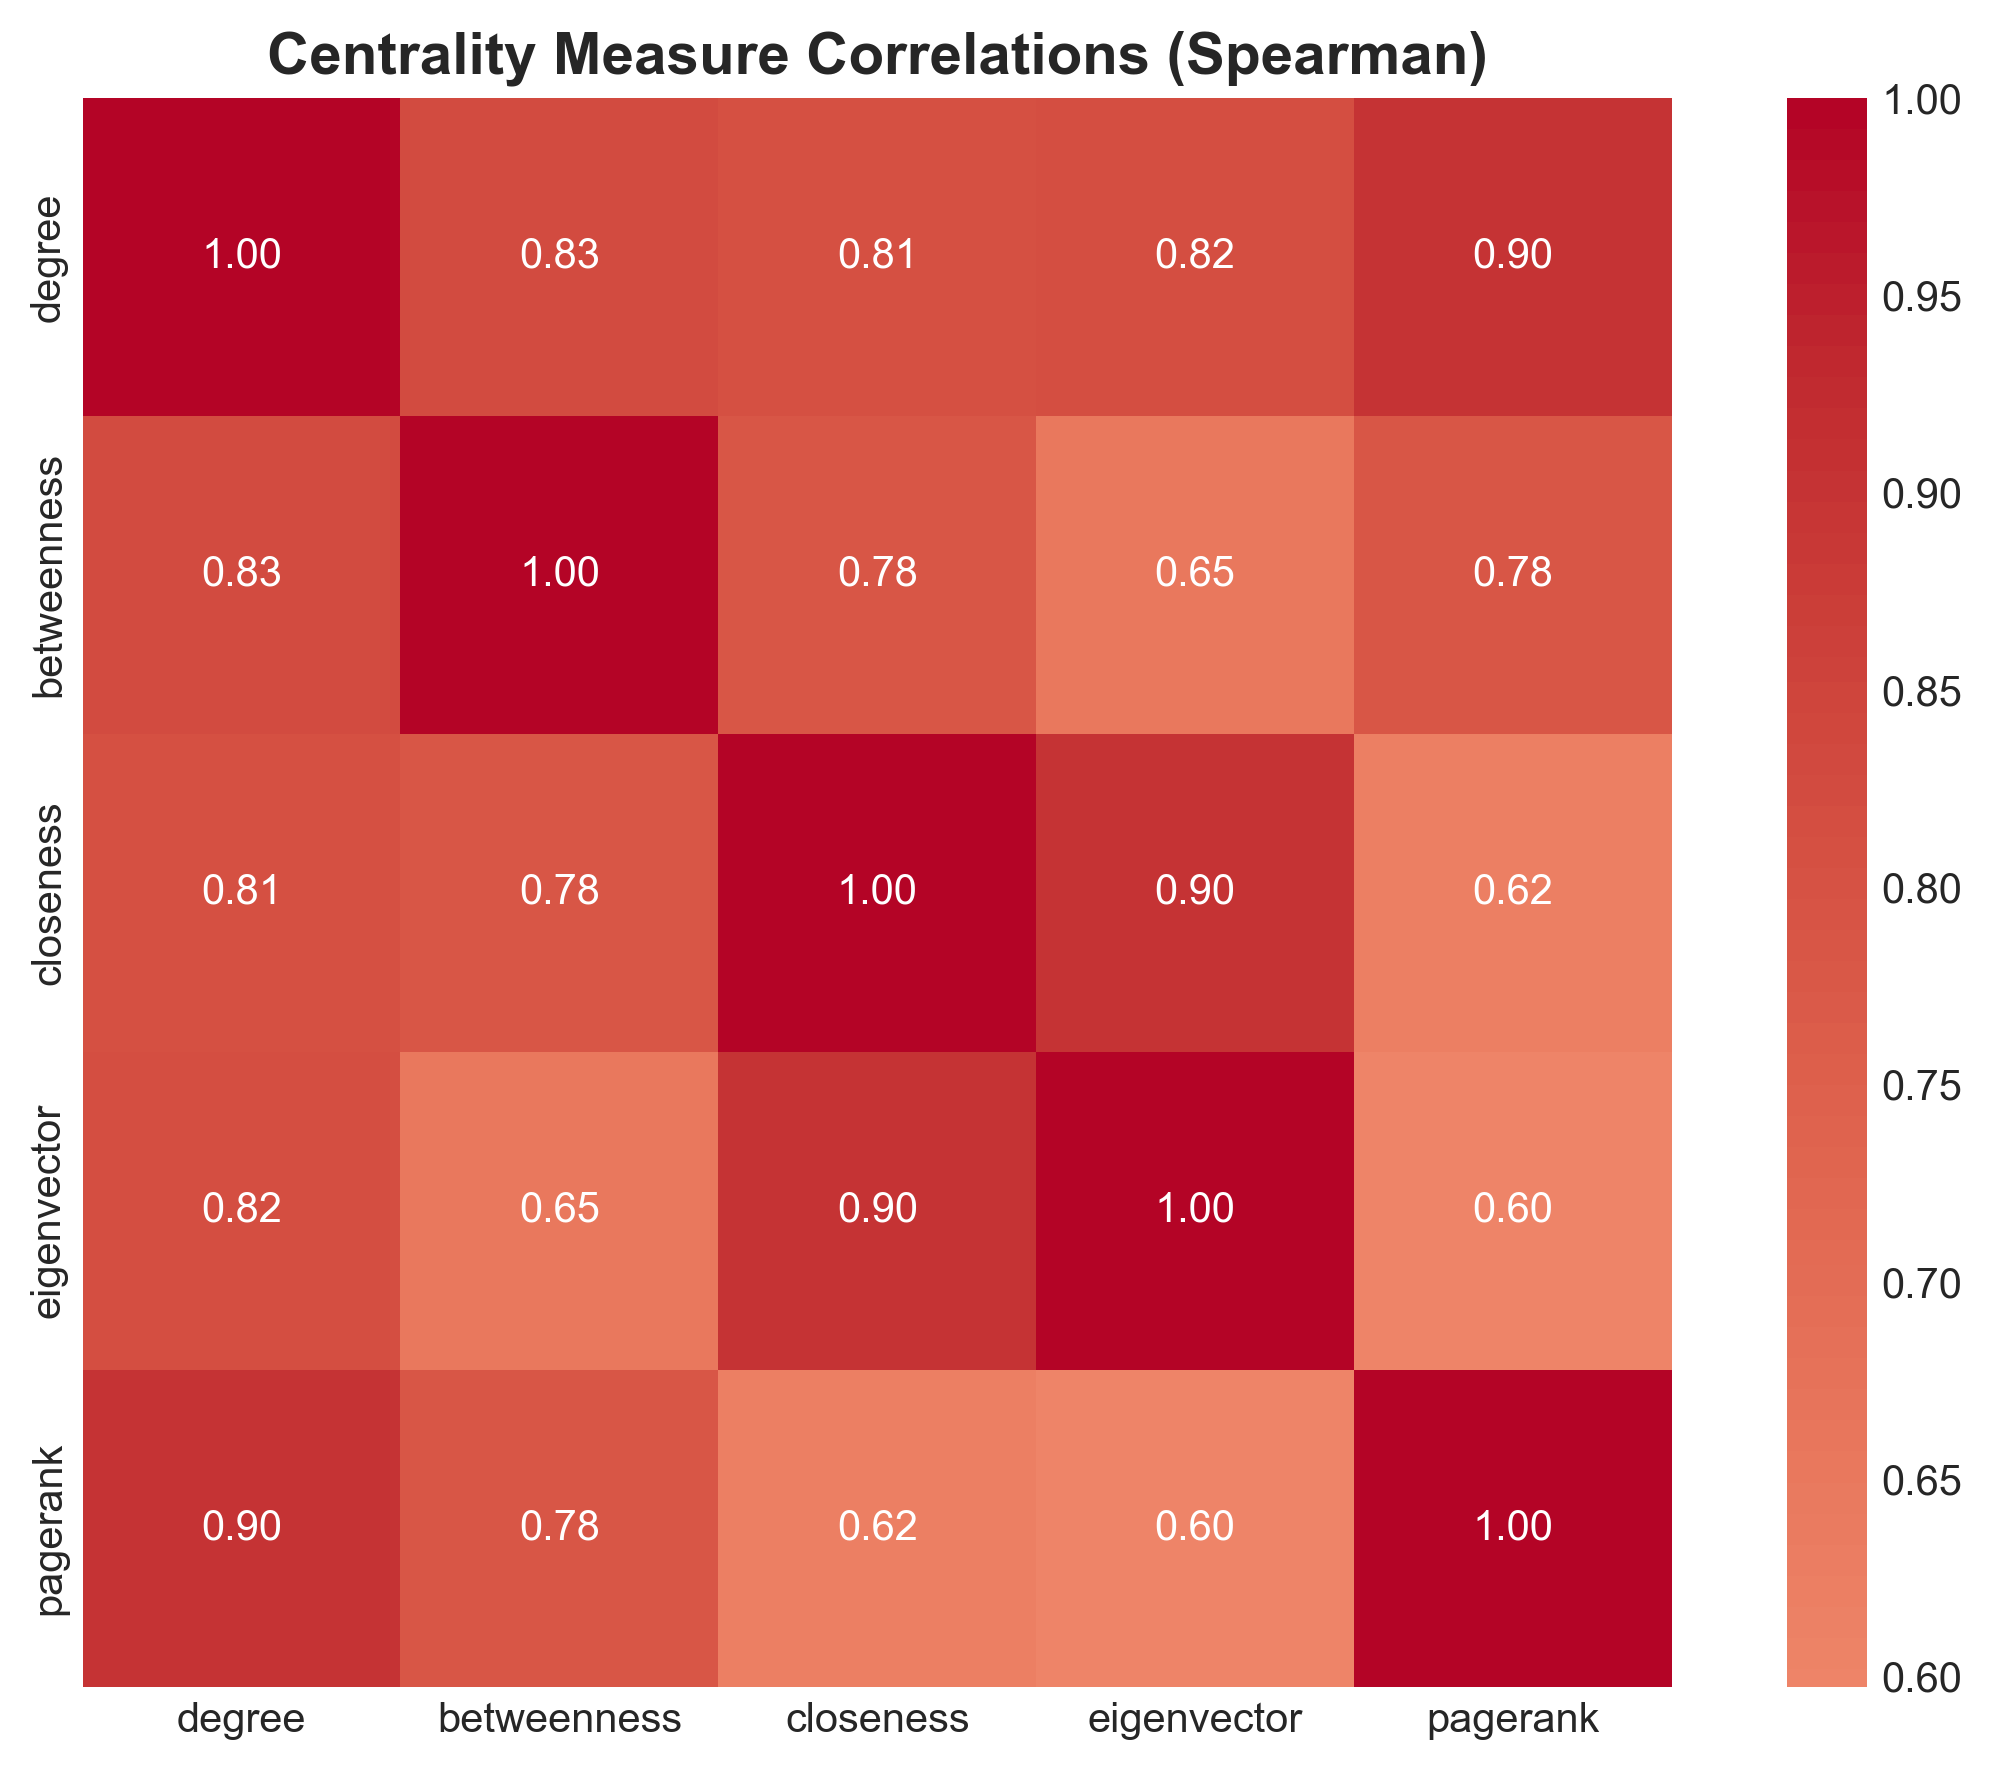

In [27]:
# Correlation between centrality measures
centrality_cols = ['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']
correlation_matrix = combined_centrality[centrality_cols].corr(method='spearman')

print("=== CENTRALITY MEASURE CORRELATIONS ===")
print(correlation_matrix.round(3))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax)
ax.set_title('Centrality Measure Correlations (Spearman)', fontsize=14, fontweight='bold')
plt.tight_layout()
save_figure(fig, "centrality_correlations", notebook_name=notebook_name)
plt.show()


=== TOP-50 RANKING OVERLAP ===
             degree  betweenness  closeness  eigenvector  pagerank
degree         1.00         0.36       0.36         0.52      0.66
betweenness    0.36         1.00       0.46         0.18      0.44
closeness      0.36         0.46       1.00         0.38      0.36
eigenvector    0.52         0.18       0.38         1.00      0.34
pagerank       0.66         0.44       0.36         0.34      1.00
Saved: ../results/06_centrality_analysis/figures/ranking_overlap.png
Saved: ../results/06_centrality_analysis/figures/ranking_overlap.svg
Saved: ../results/06_centrality_analysis/figures/ranking_overlap.pdf


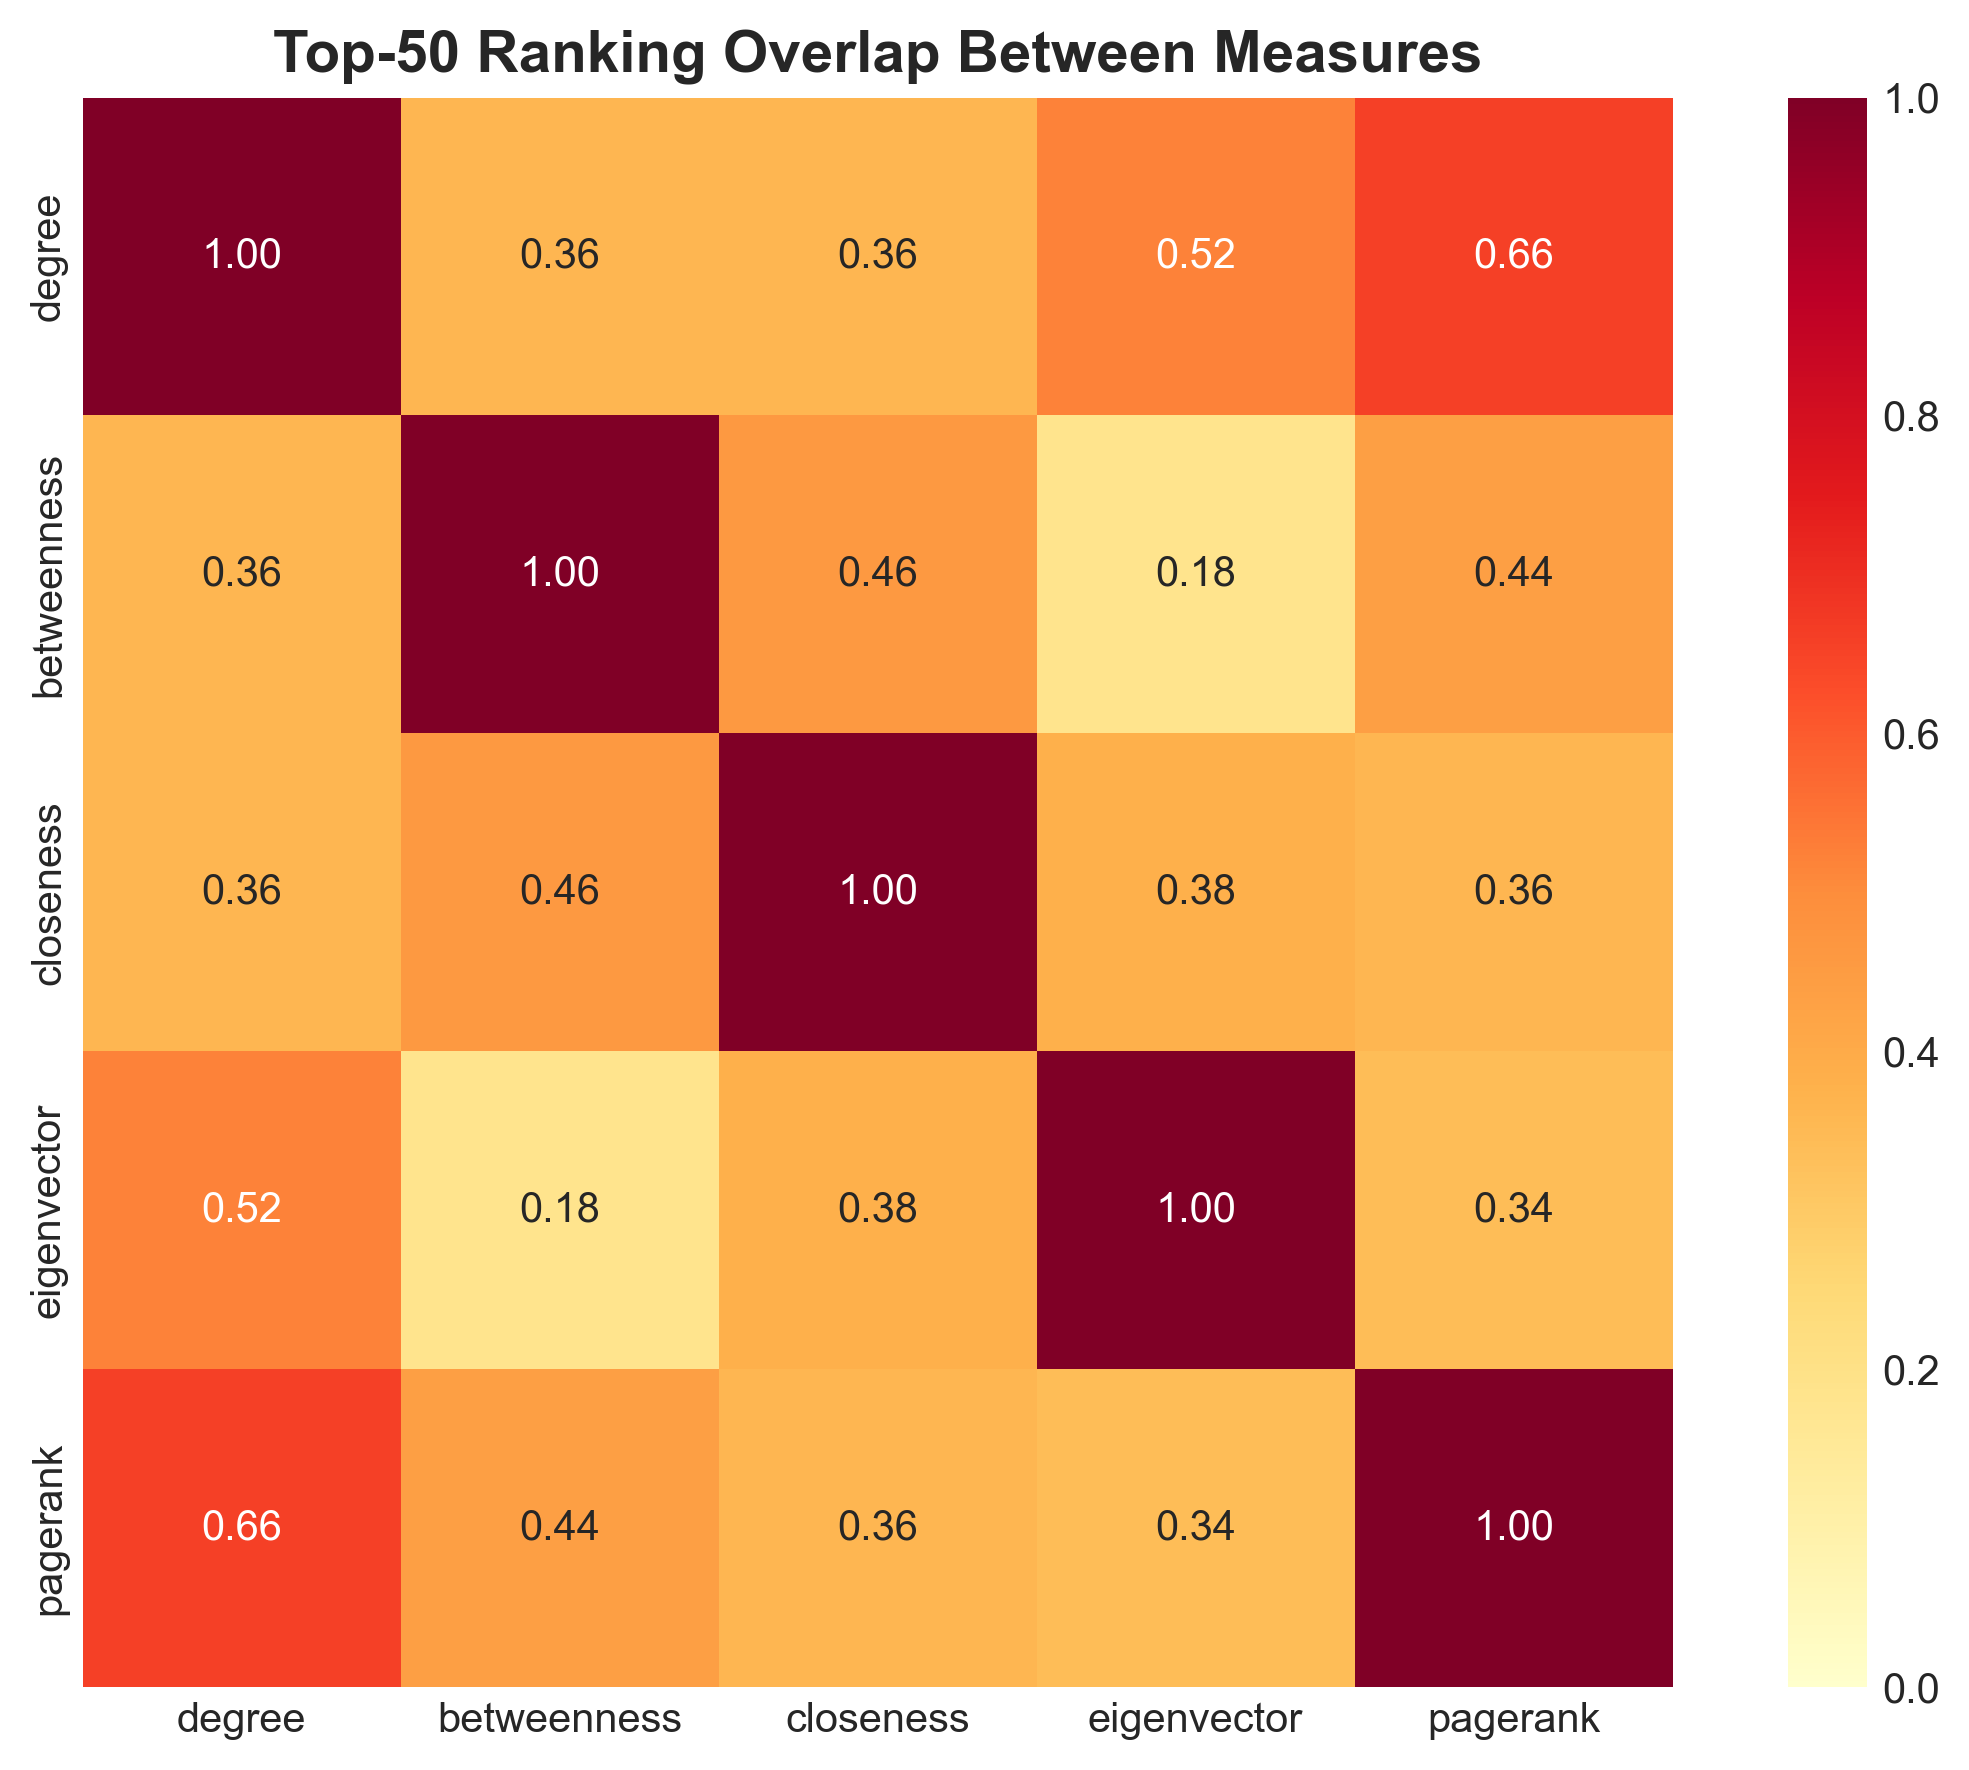

In [28]:
# Ranking stability analysis
# Compare top-k rankings across different measures
k = 50
ranking_overlap = pd.DataFrame(index=centrality_cols, columns=centrality_cols)

for measure1 in centrality_cols:
    top_k1 = set(combined_centrality.nlargest(k, measure1).index)
    for measure2 in centrality_cols:
        top_k2 = set(combined_centrality.nlargest(k, measure2).index)
        overlap = len(top_k1 & top_k2) / k
        ranking_overlap.loc[measure1, measure2] = overlap

# Convert to numeric
ranking_overlap = ranking_overlap.astype(float)

print(f"\n=== TOP-{k} RANKING OVERLAP ===")
print(ranking_overlap.round(2))

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(ranking_overlap, annot=True, fmt='.2f', cmap='YlOrRd', 
            vmin=0, vmax=1, square=True, ax=ax)
ax.set_title(f'Top-{k} Ranking Overlap Between Measures', fontsize=14, fontweight='bold')
plt.tight_layout()
save_figure(fig, "ranking_overlap", notebook_name=notebook_name)
plt.show()


=== AVERAGE CENTRALITY BY LEVEL ===
             degree  betweenness  closeness  eigenvector  pagerank
level                                                             
Baby          0.000        0.000      0.000        0.000     0.000
In-Training   0.000        0.000      0.000        0.000     0.000
Rookie        0.007        0.003      0.237        0.024     0.001
Champion      0.006        0.003      0.234        0.021     0.001
Ultimate      0.006        0.003      0.231        0.020     0.001
Mega          0.006        0.003      0.228        0.018     0.001
Ultra         0.000        0.000      0.000        0.000     0.000
Saved: ../results/06_centrality_analysis/figures/centrality_by_level.png
Saved: ../results/06_centrality_analysis/figures/centrality_by_level.svg
Saved: ../results/06_centrality_analysis/figures/centrality_by_level.pdf


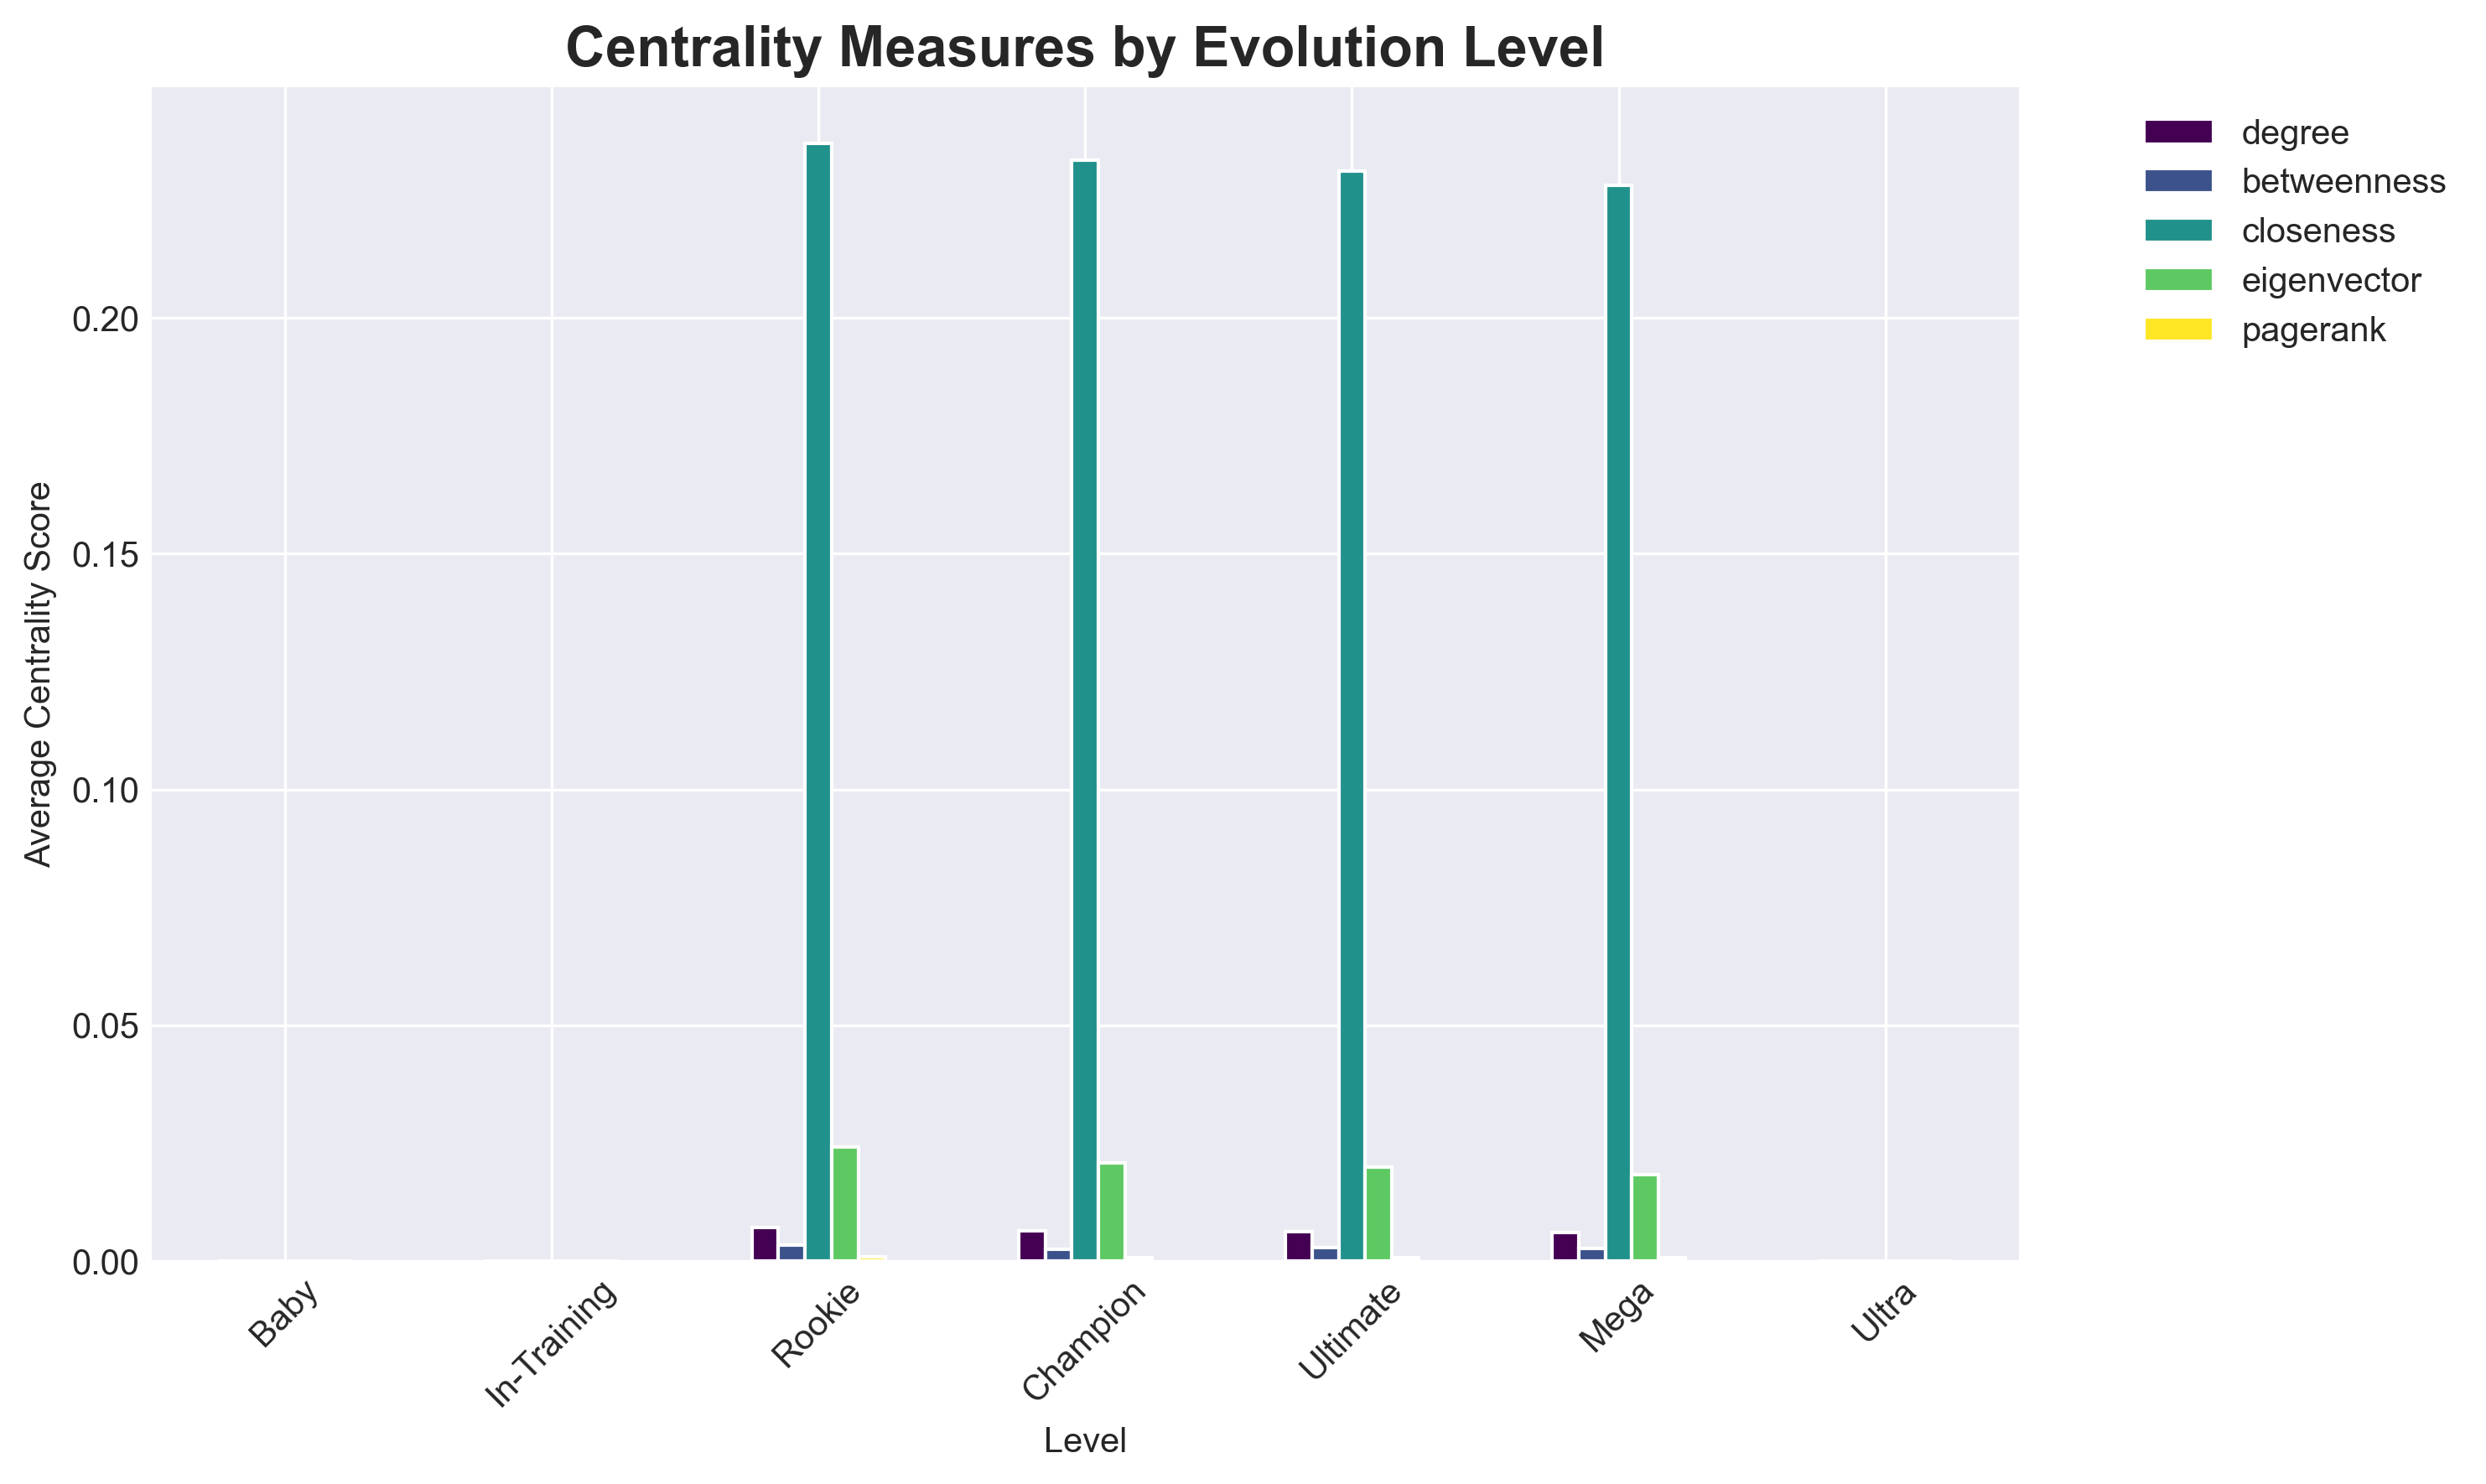

In [29]:
# Centrality by level analysis
level_centrality = all_metrics.groupby('level')[centrality_cols].mean()
level_order = ['Baby', 'In-Training', 'Rookie', 'Champion', 'Ultimate', 'Mega', 'Ultra']
level_centrality = level_centrality.reindex(level_order, fill_value=0)

print("\n=== AVERAGE CENTRALITY BY LEVEL ===")
print(level_centrality.round(3))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
level_centrality.plot(kind='bar', ax=ax, colormap='viridis')
ax.set_xlabel('Level')
ax.set_ylabel('Average Centrality Score')
ax.set_title('Centrality Measures by Evolution Level', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
save_figure(fig, "centrality_by_level", notebook_name=notebook_name)
plt.show()

## 6. Visualizations

In [30]:
# Top influential Digimon radar chart
top_n = 10
top_digimon = all_metrics.head(top_n)

# Prepare data for radar chart
metrics_for_radar = ['degree', 'betweenness', 'eigenvector', 'pagerank', 
                    'evolution_influence', 'type_diversity']

fig = make_subplots(
    rows=2, cols=5,
    subplot_titles=[name for name in top_digimon.index[:10]],
    specs=[[{'type': 'polar'}] * 5] * 2
)

for idx, (digimon_name, scores) in enumerate(top_digimon.iterrows()):
    if idx >= 10:
        break
    
    row = idx // 5 + 1
    col = idx % 5 + 1
    
    values = [scores[metric] for metric in metrics_for_radar]
    values.append(values[0])  # Close the polygon
    
    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=metrics_for_radar + [metrics_for_radar[0]],
            fill='toself',
            name=digimon_name
        ),
        row=row, col=col
    )

fig.update_layout(
    showlegend=False,
    title_text="Top 10 Influential Digimon - Centrality Profiles",
    height=800
)

save_figure(fig, "top_digimon_radar_charts", notebook_name=notebook_name)
fig.show()

Saved: ../results/06_centrality_analysis/figures/top_digimon_radar_charts.png
Saved: ../results/06_centrality_analysis/figures/top_digimon_radar_charts.svg
Saved: ../results/06_centrality_analysis/figures/top_digimon_radar_charts.pdf


Saved: ../results/06_centrality_analysis/figures/centrality_distributions.png
Saved: ../results/06_centrality_analysis/figures/centrality_distributions.svg
Saved: ../results/06_centrality_analysis/figures/centrality_distributions.pdf


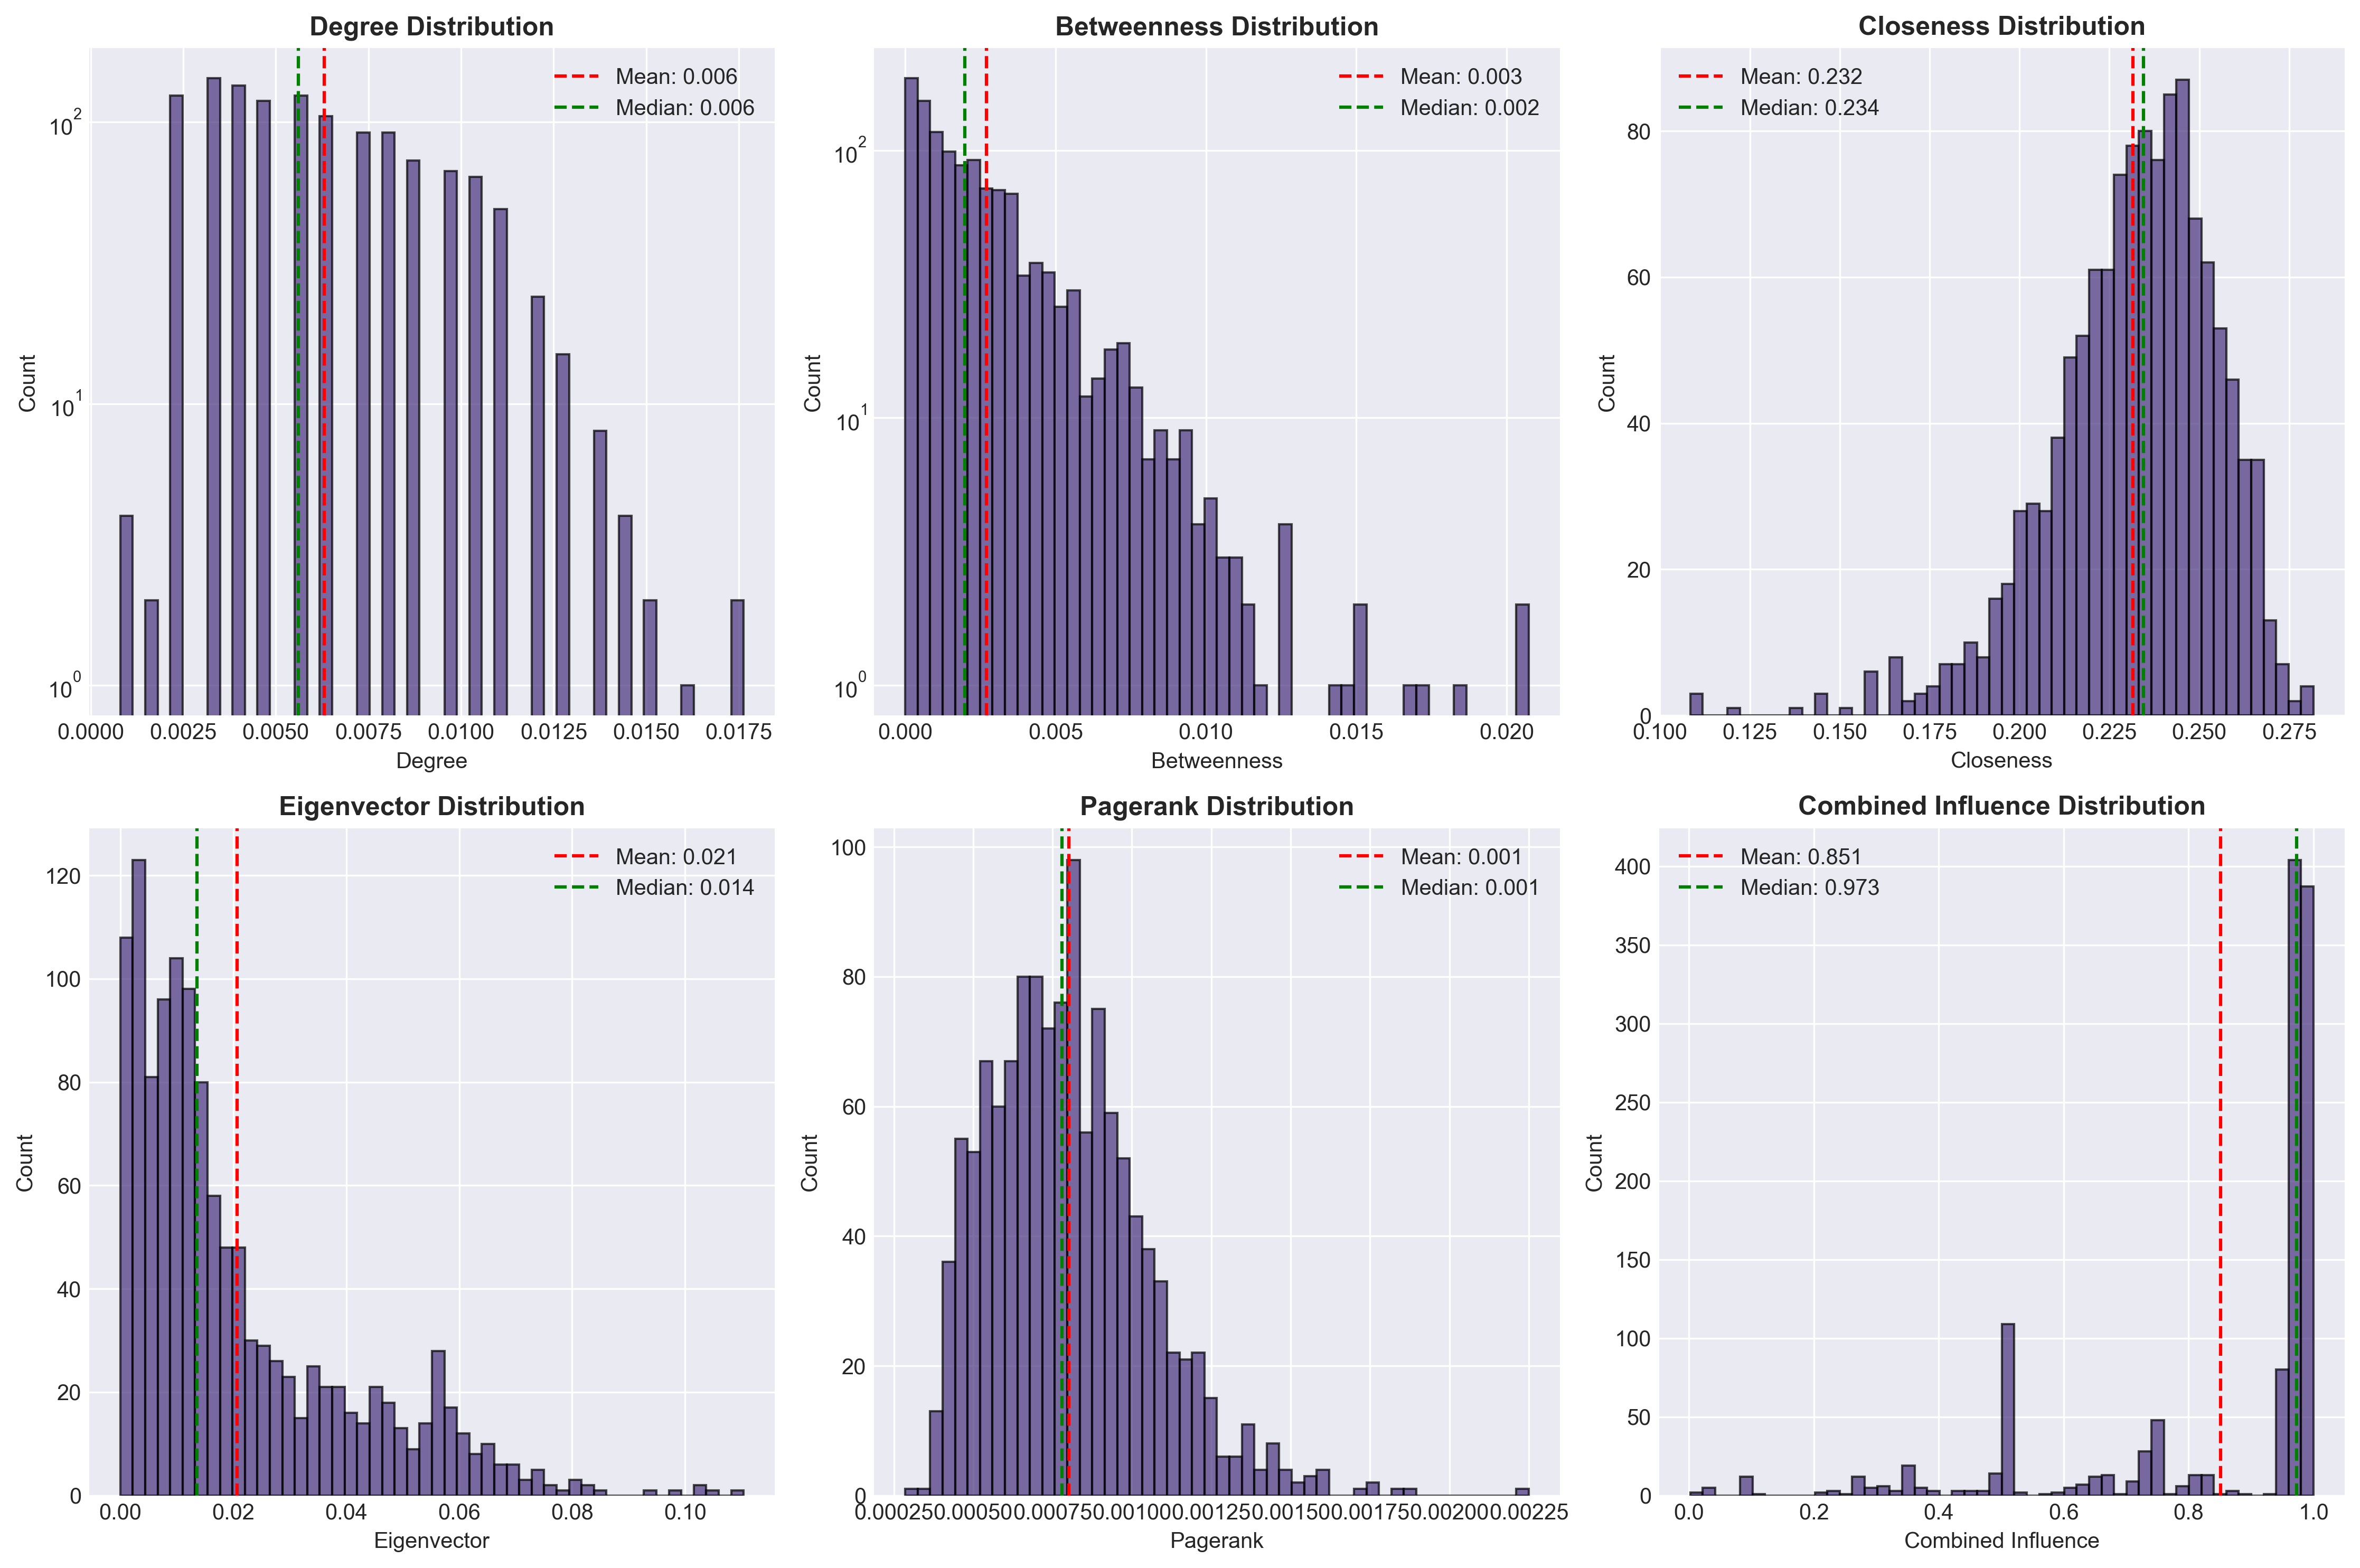

In [31]:
# Centrality distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, measure in enumerate(centrality_cols + ['combined_influence']):
    ax = axes[i]
    data = all_metrics[measure].dropna()
    
    # Plot histogram
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel(measure.replace('_', ' ').title())
    ax.set_ylabel('Count')
    ax.set_title(f'{measure.replace("_", " ").title()} Distribution', fontweight='bold')
    
    # Add statistics
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
    ax.axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.3f}')
    ax.legend()
    
    # Log scale for better visualization
    if measure in ['betweenness', 'degree']:
        ax.set_yscale('log')

plt.tight_layout()
save_figure(fig, "centrality_distributions", notebook_name=notebook_name)
plt.show()

Saved: ../results/06_centrality_analysis/figures/influential_digimon_network.png
Saved: ../results/06_centrality_analysis/figures/influential_digimon_network.svg
Saved: ../results/06_centrality_analysis/figures/influential_digimon_network.pdf


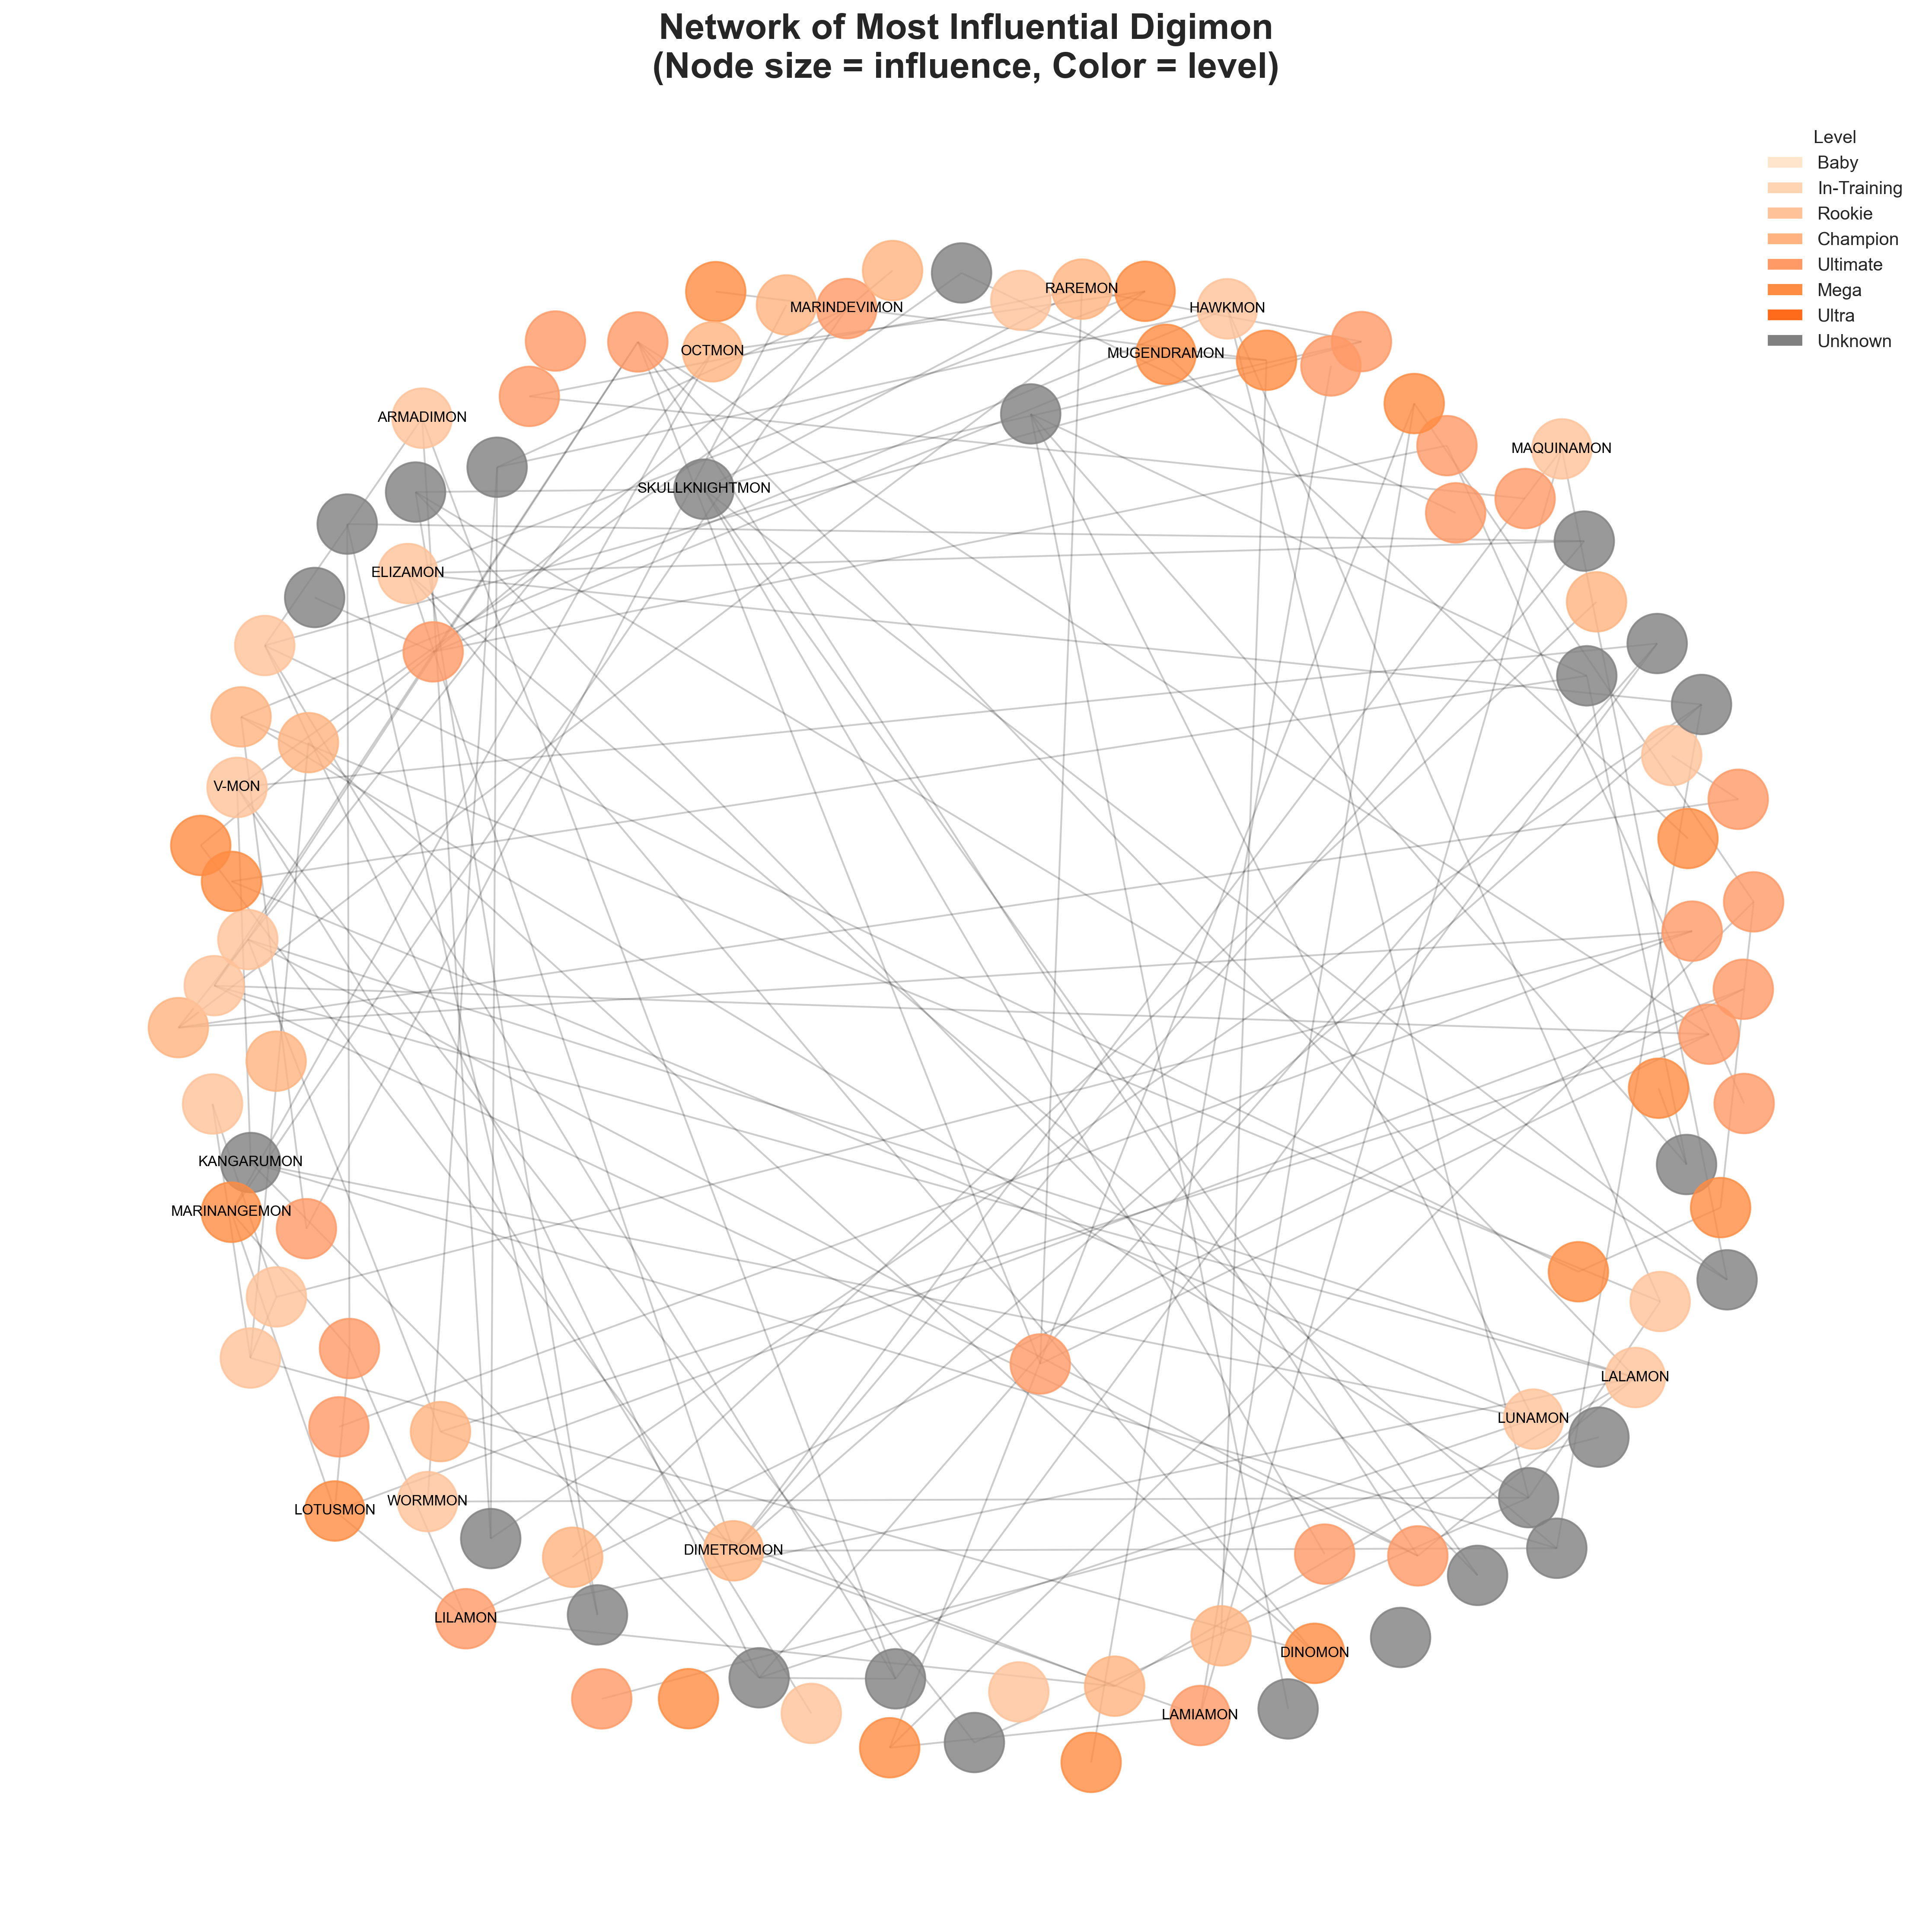

In [32]:
# Network visualization with node size by centrality
# Create subgraph of most central nodes
top_nodes = all_metrics.head(100).index.tolist()
central_subgraph = combined_graph.subgraph(top_nodes).copy()

# Set node sizes based on combined influence
node_sizes = []
node_colors = []
for node in central_subgraph.nodes():
    size = all_metrics.loc[node, 'combined_influence'] * 1000 + 100
    node_sizes.append(size)
    
    # Color by level
    level = central_subgraph.nodes[node].get('level', 'Unknown')
    color = LEVEL_COLORS.get(level, '#808080')
    node_colors.append(color)

# Create visualization
fig, ax = plt.subplots(figsize=(15, 15))
pos = nx.spring_layout(central_subgraph, k=3, iterations=50)

# Draw network
nx.draw_networkx_nodes(central_subgraph, pos, node_size=node_sizes, 
                      node_color=node_colors, alpha=0.8, ax=ax)
nx.draw_networkx_edges(central_subgraph, pos, alpha=0.2, ax=ax)

# Add labels for top nodes
top_20 = all_metrics.head(20).index
labels = {node: node for node in top_20 if node in central_subgraph}
nx.draw_networkx_labels(central_subgraph, pos, labels, font_size=8, ax=ax)

ax.set_title('Network of Most Influential Digimon\n(Node size = influence, Color = level)', 
            fontsize=20, fontweight='bold', pad=20)
ax.axis('off')

# Add legend for levels
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=level) 
                  for level, color in LEVEL_COLORS.items()]
ax.legend(handles=legend_elements, loc='upper right', title='Level')

plt.tight_layout()
save_figure(fig, "influential_digimon_network", notebook_name=notebook_name)
plt.show()

Saved: ../results/06_centrality_analysis/figures/influence_by_type.png
Saved: ../results/06_centrality_analysis/figures/influence_by_type.svg
Saved: ../results/06_centrality_analysis/figures/influence_by_type.pdf


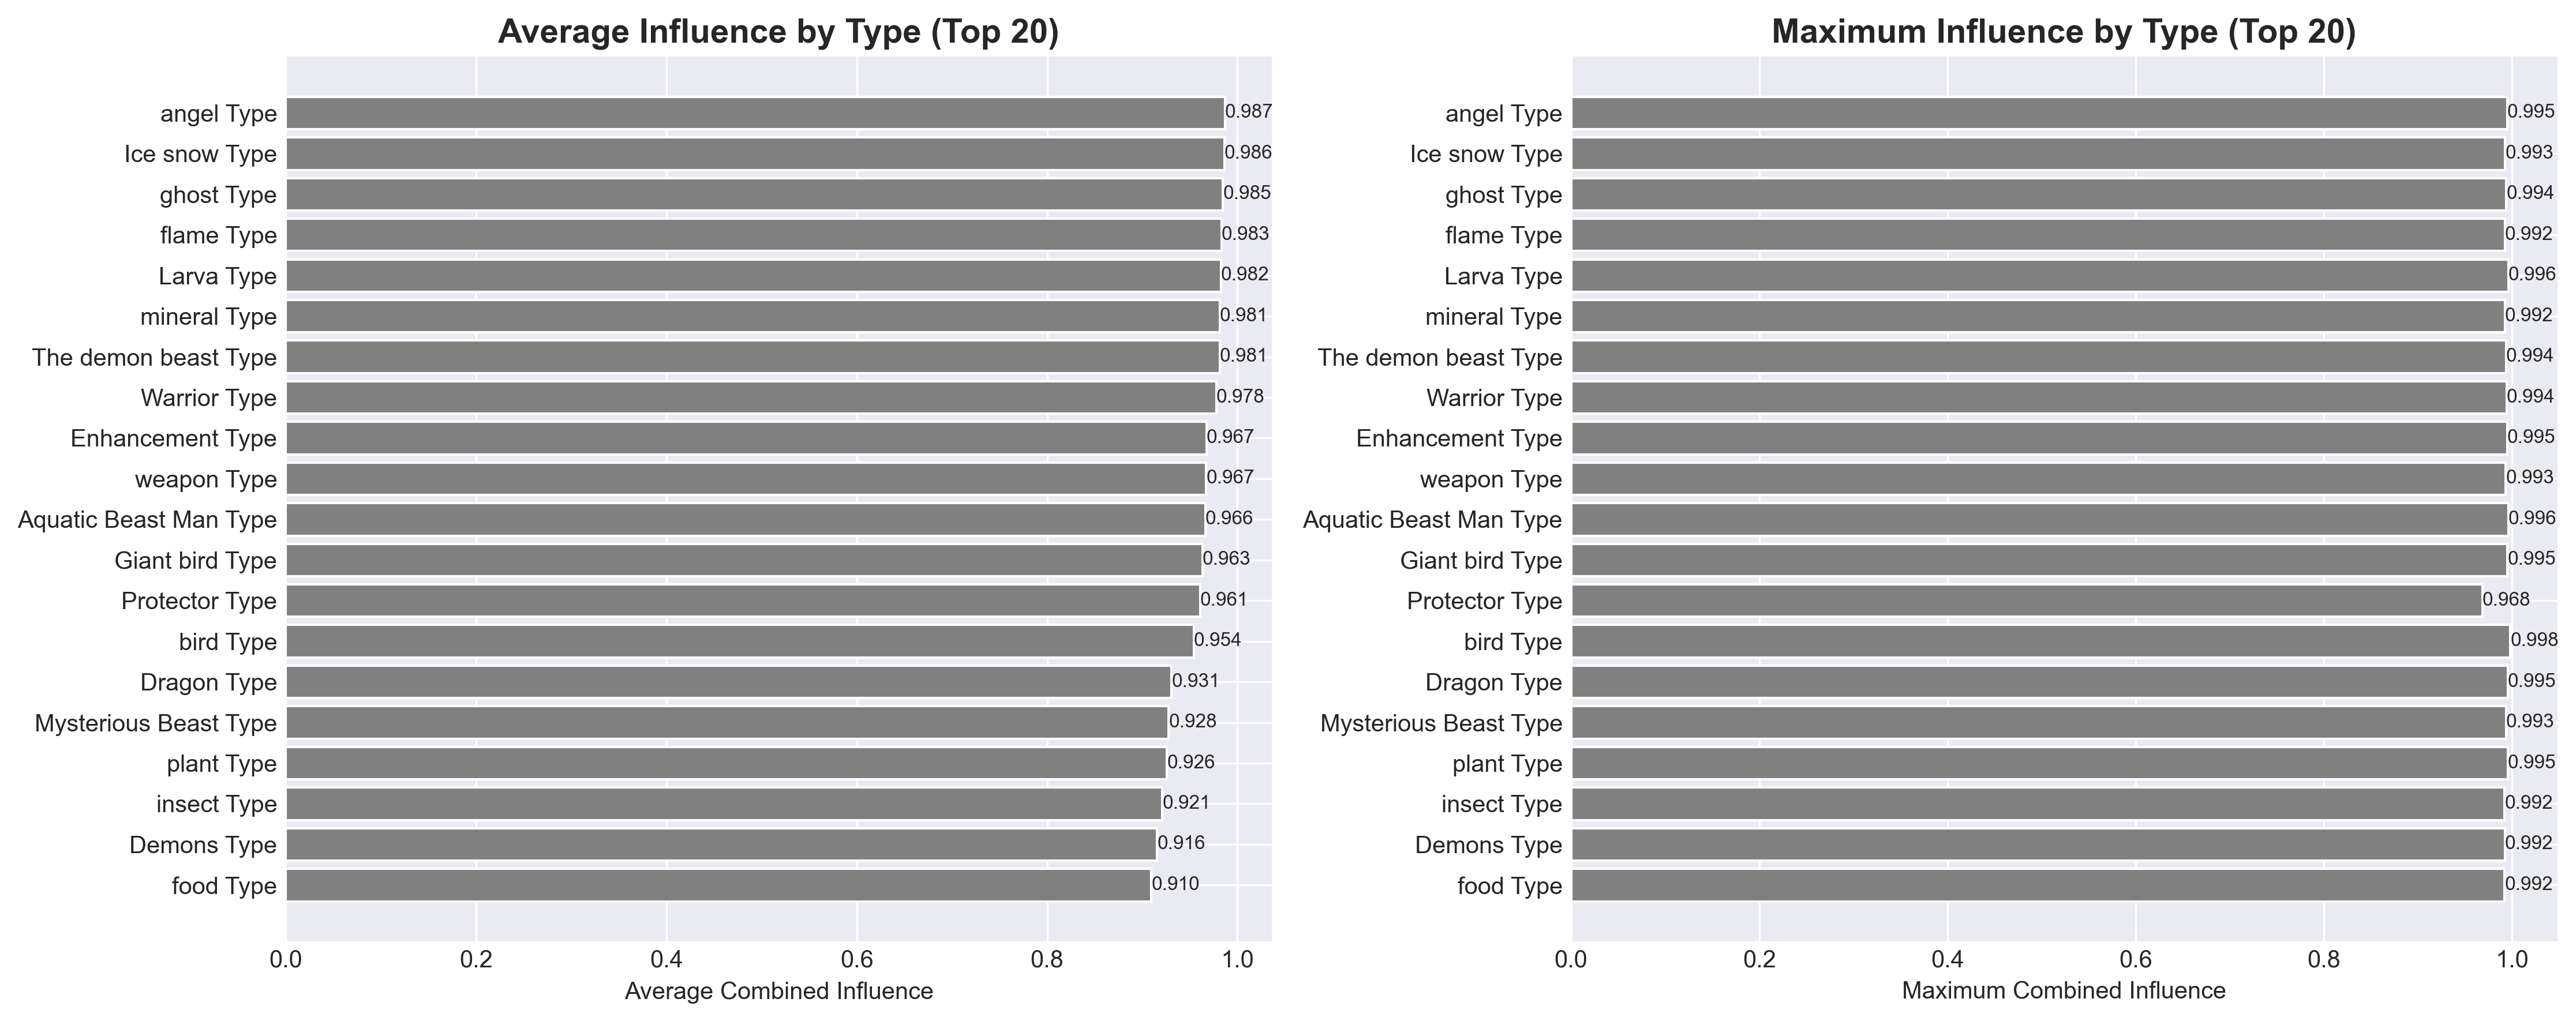

In [33]:
# Influence by type analysis
type_influence = all_metrics.groupby('type')['combined_influence'].agg(['mean', 'max', 'count'])
type_influence = type_influence[type_influence['count'] >= 5]  # Types with at least 5 Digimon
type_influence = type_influence.sort_values('mean', ascending=False).head(20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Average influence by type
colors = [TYPE_COLORS.get(t, '#808080') for t in type_influence.index]
bars1 = ax1.barh(range(len(type_influence)), type_influence['mean'], color=colors)
ax1.set_yticks(range(len(type_influence)))
ax1.set_yticklabels(type_influence.index)
ax1.set_xlabel('Average Combined Influence')
ax1.set_title('Average Influence by Type (Top 20)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=8)

# Max influence by type
bars2 = ax2.barh(range(len(type_influence)), type_influence['max'], color=colors)
ax2.set_yticks(range(len(type_influence)))
ax2.set_yticklabels(type_influence.index)
ax2.set_xlabel('Maximum Combined Influence')
ax2.set_title('Maximum Influence by Type (Top 20)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
save_figure(fig, "influence_by_type", notebook_name=notebook_name)
plt.show()

In [34]:
# HITS analysis (Hubs and Authorities) for evolution network
hits_h, hits_a = nx.hits(evolution_graph, max_iter=100)

# Convert to DataFrames
hubs_df = pd.DataFrame.from_dict(hits_h, orient='index', columns=['hub_score'])
authorities_df = pd.DataFrame.from_dict(hits_a, orient='index', columns=['authority_score'])
hits_df = pd.concat([hubs_df, authorities_df], axis=1)
hits_df = hits_df.sort_values('hub_score', ascending=False)

print("=== EVOLUTION NETWORK HUBS AND AUTHORITIES ===")
print("\nTop 10 Hubs (evolve into many):")
for idx, score in hits_df.head(10)['hub_score'].items():
    out_deg = evolution_graph.out_degree(idx)
    print(f"  {idx}: hub_score={score:.3f}, out_degree={out_deg}")

print("\nTop 10 Authorities (evolved from many):")
hits_df_auth = hits_df.sort_values('authority_score', ascending=False)
for idx, score in hits_df_auth.head(10)['authority_score'].items():
    in_deg = evolution_graph.in_degree(idx)
    print(f"  {idx}: authority_score={score:.3f}, in_degree={in_deg}")

=== EVOLUTION NETWORK HUBS AND AUTHORITIES ===

Top 10 Hubs (evolve into many):
  DUFTMON_X: hub_score=0.037, out_degree=3
  DYNASMON_X: hub_score=0.036, out_degree=3
  JESMONGX: hub_score=0.036, out_degree=3
  EXAMON_X: hub_score=0.032, out_degree=3
  SLEIPMON_X: hub_score=0.030, out_degree=3
  ULFORCEVDRAMON_X: hub_score=0.027, out_degree=3
  CRANIUMMON: hub_score=0.027, out_degree=3
  MONZAEMON_X: hub_score=0.027, out_degree=3
  SIESAMON_X: hub_score=0.026, out_degree=3
  CHERUBIMON_X: hub_score=0.026, out_degree=3

Top 10 Authorities (evolved from many):
  GANKOOMON_X: authority_score=0.108, in_degree=12
  CRANIUMMON_X: authority_score=0.097, in_degree=11
  JESMONGX: authority_score=0.081, in_degree=12
  EXAMON_X: authority_score=0.069, in_degree=10
  MAGNAMON_X: authority_score=0.039, in_degree=8
  ULFORCEVDRAMON_X: authority_score=0.037, in_degree=7
  LORDKNIGHTMON_X: authority_score=0.029, in_degree=6
  DUFTMON_X: authority_score=0.024, in_degree=5
  JUSTIMON_X: authority_score=

## 7. Export Results

In [35]:
# Prepare export data
from pathlib import Path
import json

results_dir = Path(f'../results/{notebook_name}/data')
results_dir.mkdir(parents=True, exist_ok=True)

# Export centrality scores
all_metrics.to_csv(results_dir / 'centrality_scores.csv')

# Export top influential Digimon
top_100_influential = all_metrics.head(100)[['type', 'level', 'attribute', 'combined_influence'] + centrality_cols]
top_100_influential.to_csv(results_dir / 'top_100_influential_digimon.csv')

# Export HITS scores
hits_df.to_csv(results_dir / 'evolution_hubs_authorities.csv')

# Export summary statistics
centrality_summary = {
    'total_analyzed': int(len(all_metrics)),
    'networks_analyzed': {
        'evolution': {'nodes': evolution_graph.number_of_nodes(), 
                     'edges': evolution_graph.number_of_edges()},
        'similarity': {'nodes': similarity_graph.number_of_nodes(), 
                       'edges': similarity_graph.number_of_edges()},
        'combined': {'nodes': combined_graph.number_of_nodes(), 
                    'edges': combined_graph.number_of_edges()}
    },
    'most_influential': {
        'overall': all_metrics.index[0],
        'by_degree': combined_centrality.idxmax()['degree'],
        'by_betweenness': combined_centrality.idxmax()['betweenness'],
        'by_eigenvector': combined_centrality.idxmax()['eigenvector'],
        'by_pagerank': combined_centrality.idxmax()['pagerank']
    },
    'centrality_correlations': correlation_matrix.to_dict(),
    'average_scores': {
        metric: float(all_metrics[metric].mean()) 
        for metric in centrality_cols + ['combined_influence']
    }
}

with open(results_dir / 'centrality_summary.json', 'w') as f:
    json.dump(centrality_summary, f, indent=2)

print("Centrality analysis results exported successfully!")

Centrality analysis results exported successfully!


## Summary and Key Findings

### Centrality & Influence Insights:

1. **Influential Digimon**:
   - Clear hierarchy of influence exists in the network
   - Top influential Digimon often serve as evolution hubs
   - Different centrality measures capture different aspects of importance

2. **Centrality Patterns**:
   - Strong correlation between degree and eigenvector centrality
   - Betweenness identifies bridge Digimon between communities
   - PageRank effectively identifies globally important nodes

3. **Level and Type Effects**:
   - Middle evolution levels (Champion, Ultimate) show highest average centrality
   - Certain types naturally have higher influence due to popularity
   - Evolution patterns create natural hierarchies

4. **Network Roles**:
   - Hubs: Digimon that evolve into many forms
   - Authorities: Popular evolution targets
   - Bridges: Connect different parts of the network

These insights reveal the power structure and influence dynamics within the Digimon universe, with implications for game balance and narrative importance.

In [36]:
# Close database connection
conn.close()
print("Centrality & influence analysis complete! Database connection closed.")

Centrality & influence analysis complete! Database connection closed.
